In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from wordcloud import WordCloud

nltk.download('vader_lexicon')
nltk.download('punkt')

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [3]:
df_train =  pd.read_csv('../input/twitter-entity-sentiment-analysis/twitter_training.csv')
df_test =  pd.read_csv('../input/twitter-entity-sentiment-analysis/twitter_validation.csv')

In [4]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
df_train.columns = ['No.', 'User', 'Metrics', 'Statement']
df_train.head()

,No.,User,Metrics,Statement
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
df_test.columns = ['No.', 'User', 'Metrics', 'Statement']
df_test.head()

,No.,User,Metrics,Statement
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [7]:
df_train.isna().any()

No.          False
User         False
Metrics      False
Statement     True
dtype: bool

In [8]:
df_test.isna().any()

No.          False
User         False
Metrics      False
Statement    False
dtype: bool

In [9]:
df_train = df_train.dropna(subset=['Statement'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   No.        73995 non-null  int64 
 1   User       73995 non-null  object
 2   Metrics    73995 non-null  object
 3   Statement  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [10]:
df_train.isna().sum()

No.          0
User         0
Metrics      0
Statement    0
dtype: int64

In [11]:
sample = df_train['Statement'].loc[1]
sample

'im getting on borderlands and i will kill you all,'

In [12]:
df_train['Metrics'].value_counts()

Metrics
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

In [13]:
df_test['Metrics'].value_counts()

Metrics
Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: count, dtype: int64

In [14]:


sentiment_mapping = {
    'Positive': 3,
    'Neutral': 2,
    'Negative': 1,
    'Irrelevant': 2,
}

# Apply the mapping to df_train
df_train['encoded_metrics'] = df_train['Metrics'].map(sentiment_mapping)

# Apply the mapping to df_test
df_test['encoded_metrics'] = df_test['Metrics'].map(sentiment_mapping)





In [15]:
df_train.isna().sum()

No.                0
User               0
Metrics            0
Statement          0
encoded_metrics    0
dtype: int64

In [16]:
df_test.head()

,No.,User,Metrics,Statement,encoded_metrics
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,2
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,1
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",1
3,4433,Google,Neutral,Now the President is slapping Americans in the...,2
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,1


In [17]:
df_train.head()

,No.,User,Metrics,Statement,encoded_metrics
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,3
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,3
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,3
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,3
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,3


In [18]:
def remove_special_characters(text, remove_digits=False, remove_emojis=False):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s#@]', ' ', text)
    if remove_digits:
        text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    if remove_emojis:
        text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    return text

df_train['Metrics'] = df_train['Metrics'].apply(remove_special_characters, remove_digits=True, remove_emojis=False)
df_test['Metrics'] = df_test['Metrics'].apply(remove_special_characters, remove_digits=True, remove_emojis=False)


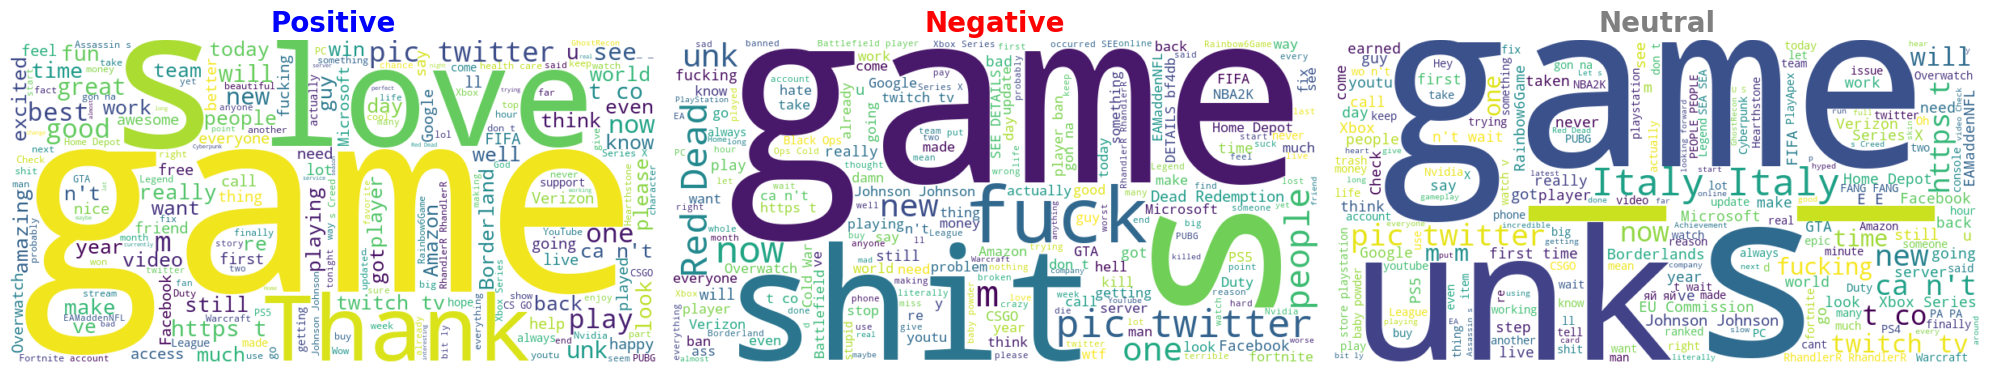

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(review):
    score = sid.polarity_scores(review)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis function to the Statement column
df_train['Metrics'] = df_train['Statement'].apply(get_sentiment)

# Tokenize the reviews
df_train['tokens'] = df_train['Statement'].apply(word_tokenize)  # Corrected DataFrame reference

# Function to generate word cloud
def generate_wordcloud(tokens):
    flat_tokens = [token for sublist in tokens for token in sublist]
    text = ' '.join(flat_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    return wordcloud

# Separate positive, negative, and neutral reviews
positive_reviews = df_train[df_train['Metrics'] == 'Positive']['tokens']  # Corrected condition
negative_reviews = df_train[df_train['Metrics'] == 'Negative']['tokens']  # Corrected condition
neutral_reviews = df_train[df_train['Metrics'] == 'Neutral']['tokens']  # Add neutral reviews

# Plot the word clouds
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))  # Change to 3 columns

# Check and generate word cloud for positive reviews
if not positive_reviews.empty:
    positive_wordcloud = generate_wordcloud(positive_reviews)
    axs[0].imshow(positive_wordcloud, interpolation='bilinear')
    axs[0].set_title('Positive', fontsize=20, fontweight='bold', color='blue')
    axs[0].axis('off')
else:
    axs[0].text(0.5, 0.5, 'No Positive Reviews', fontsize=20, ha='center')
    axs[0].set_title('Positive', fontsize=20, fontweight='bold', color='blue')
    axs[0].axis('off')

# Check and generate word cloud for negative reviews
if not negative_reviews.empty:
    negative_wordcloud = generate_wordcloud(negative_reviews)
    axs[1].imshow(negative_wordcloud, interpolation='bilinear')
    axs[1].set_title('Negative', fontsize=20, fontweight='bold', color='red')
    axs[1].axis('off')
else:
    axs[1].text(0.5, 0.5, 'No Negative Reviews', fontsize=20, ha='center')
    axs[1].set_title('Negative', fontsize=20, fontweight='bold', color='red')
    axs[1].axis('off')

# Check and generate word cloud for neutral reviews
if not neutral_reviews.empty:
    neutral_wordcloud = generate_wordcloud(neutral_reviews)
    axs[2].imshow(neutral_wordcloud, interpolation='bilinear')
    axs[2].set_title('Neutral', fontsize=20, fontweight='bold', color='grey')
    axs[2].axis('off')
else:
    axs[2].text(0.5, 0.5, 'No Neutral Reviews', fontsize=20, ha='center')
    axs[2].set_title('Neutral', fontsize=20, fontweight='bold', color='grey')
    axs[2].axis('off')

plt.tight_layout()
plt.show()


In [20]:
''''
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(review):
    score = sid.polarity_scores(review)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis function to the Statement column of df_test
df_test['Metrics'] = df_test['Statement'].apply(get_sentiment)

# Filter out neutral reviews from df_test
df_test = df_test[df_test['Metrics'] != 'Neutral']

# Tokenize the reviews in df_test
df_test['tokens'] = df_test['Statement'].apply(word_tokenize)

# Function to generate word cloud
def generate_wordcloud(tokens):
    flat_tokens = [token for sublist in tokens for token in sublist]
    text = ' '.join(flat_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    return wordcloud

# Separate positive and negative reviews from df_test
positive_reviews_test = df_test[df_test['Metrics'] == 'Positive']['tokens']
negative_reviews_test = df_test[df_test['Metrics'] == 'Negative']['tokens']

# Plot the word clouds for df_test
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# Check and generate word cloud for positive reviews
if not positive_reviews_test.empty:
    positive_wordcloud = generate_wordcloud(positive_reviews_test)
    axs[0].imshow(positive_wordcloud, interpolation='bilinear')
    axs[0].set_title('Positive Reviews (Test Set)', fontsize=20, fontweight='bold', color='blue')
    axs[0].axis('off')
else:
    axs[0].text(0.5, 0.5, 'No Positive Reviews', fontsize=20, ha='center')
    axs[0].set_title('Positive Reviews (Test Set)', fontsize=20, fontweight='bold', color='blue')
    axs[0].axis('off')

# Check and generate word cloud for negative reviews
if not negative_reviews_test.empty:
    negative_wordcloud = generate_wordcloud(negative_reviews_test)
    axs[1].imshow(negative_wordcloud, interpolation='bilinear')
    axs[1].set_title('Negative Reviews (Test Set)', fontsize=20, fontweight='bold', color='red')
    axs[1].axis('off')
else:
    axs[1].text(0.5, 0.5, 'No Negative Reviews', fontsize=20, ha='center')
    axs[1].set_title('Negative Reviews (Test Set)', fontsize=20, fontweight='bold', color='red')
    axs[1].axis('off')

plt.tight_layout()
plt.show()
'''''

"'\nfrom nltk.sentiment import SentimentIntensityAnalyzer\nfrom wordcloud import WordCloud\nimport matplotlib.pyplot as plt\nfrom nltk.tokenize import word_tokenize\n\n# Initialize the sentiment analyzer\nsid = SentimentIntensityAnalyzer()\n\n# Function to classify sentiment\ndef get_sentiment(review):\n    score = sid.polarity_scores(review)['compound']\n    if score >= 0.05:\n        return 'Positive'\n    elif score <= -0.05:\n        return 'Negative'\n    else:\n        return 'Neutral'\n\n# Apply the sentiment analysis function to the Statement column of df_test\ndf_test['Metrics'] = df_test['Statement'].apply(get_sentiment)\n\n# Filter out neutral reviews from df_test\ndf_test = df_test[df_test['Metrics'] != 'Neutral']\n\n# Tokenize the reviews in df_test\ndf_test['tokens'] = df_test['Statement'].apply(word_tokenize)\n\n# Function to generate word cloud\ndef generate_wordcloud(tokens):\n    flat_tokens = [token for sublist in tokens for token in sublist]\n    text = ' '.join(fla

In [21]:
import warnings
warnings.filterwarnings("ignore")

X = df_train['Statement'] 
y = df_train['encoded_metrics']

In [22]:
X.isna().any()

False

In [23]:
y.info()

<class 'pandas.core.series.Series'>
Index: 73995 entries, 0 to 74680
Series name: encoded_metrics
Non-Null Count  Dtype
--------------  -----
73995 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, train_size=0.9)

from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize the TfidfVectorizer
vec = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    strip_accents='unicode',
    use_idf=1,
    smooth_idf=1,
    sublinear_tf=1,
    binary=1,
    stop_words='english'
)

# Fit and transform the training data
X_train_vec = vec.fit_transform(X_train)

# Transform the validation data
X_valid_vec = vec.transform(X_valid)

# Check the shapes of the transformed data
print(X_train_vec.shape)
print(X_valid_vec.shape)

(66595, 105420)
(7400, 105420)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix

# Initialize and train the model
model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000, random_state=42)
clf = model.fit(X_train_vec, y_train)

# Make predictions
probabilities = clf.predict_proba(X_valid_vec)
predictions = clf.predict(X_valid_vec)

# Calculate log loss
loss = log_loss(y_valid, probabilities)
print("Cross entropy loss:", loss)

# Calculate accuracy
score = accuracy_score(y_valid, predictions)
print("Accuracy:", score)

# Print confusion matrix and classification report
print(confusion_matrix(y_valid, predictions))
print(classification_report(y_valid, predictions))


Cross entropy loss: 0.5012570508038197
Accuracy: 0.8843243243243243
[[1895  227   74]
 [ 138 2889  111]
 [  85  221 1760]]
              precision    recall  f1-score   support

           1       0.89      0.86      0.88      2196
           2       0.87      0.92      0.89      3138
           3       0.90      0.85      0.88      2066

    accuracy                           0.88      7400
   macro avg       0.89      0.88      0.88      7400
weighted avg       0.89      0.88      0.88      7400



In [26]:
#Randomforest here
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators
rf_model.fit(X_train_vec, y_train)

# Step 4: Make predictions on the validation set
valid_predictions = rf_model.predict(X_valid_vec)
valid_probabilities = rf_model.predict_proba(X_valid_vec)

# Evaluate the model
loss = log_loss(y_valid, valid_probabilities)
accuracy = accuracy_score(y_valid, valid_predictions)

print("Cross entropy loss (Log Loss):", loss)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_valid, valid_predictions))
print("Classification Report:\n", classification_report(y_valid, valid_predictions))

# If you want to apply the model to df_test:
X_test_vec = vec.transform(df_test['Statement'])
test_predictions = rf_model.predict(X_test_vec)

# Evaluate on test set if you have the labels
if 'encoded_metrics' in df_test.columns:
    test_probabilities = rf_model.predict_proba(X_test_vec)
    test_loss = log_loss(df_test['encoded_metrics'], test_probabilities)
    test_accuracy = accuracy_score(df_test['encoded_metrics'], test_predictions)
    
    print("Test Cross entropy loss (Log Loss):", test_loss)
    print("Test Accuracy:", test_accuracy)
    print("Test Confusion Matrix:\n", confusion_matrix(df_test['encoded_metrics'], test_predictions))
    print("Test Classification Report:\n", classification_report(df_test['encoded_metrics'], test_predictions))

Cross entropy loss (Log Loss): 0.3226079755218672
Accuracy: 0.9159459459459459
Confusion Matrix:
 [[1971  167   58]
 [  84 2966   88]
 [  50  175 1841]]
Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.90      0.92      2196
           2       0.90      0.95      0.92      3138
           3       0.93      0.89      0.91      2066

    accuracy                           0.92      7400
   macro avg       0.92      0.91      0.92      7400
weighted avg       0.92      0.92      0.92      7400

Test Cross entropy loss (Log Loss): 0.14460674559891423
Test Accuracy: 0.95995995995996
Test Confusion Matrix:
 [[252  10   4]
 [  8 444   4]
 [  4  10 263]]
Test Classification Report:
               precision    recall  f1-score   support

           1       0.95      0.95      0.95       266
           2       0.96      0.97      0.97       456
           3       0.97      0.95      0.96       277

    accuracy                         